# 1. Load Packages

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('analysis-tools')
from analysis_tools.common.utils import *
from analysis_tools import utils, random, eda

import tensorflow as tf
utils.set_memory_growth()
random.set_random_seed_tf()

exp_name = "GRU"
class PATH:
    root   = abspath('.')
    input  = join(root, 'data')
    output = join(root, 'output')
    ckpt   = join(root, 'ckpt', exp_name)
    eda    = join(root, 'eda', exp_name)    

2022-08-16 16:20:36.204087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 16:20:36.207843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-16 16:20:36.208007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 2. Load Dataset
- TurbID \
Wind turbine ID, 발전기 ID (1~134)
- Day \
Day of the record, 날짜 (1~222)
- Tmstamp(HH:MM) \
Created time of the record, 시간 (00:00 ~ 23:50)
- Wspd(m/s) \
The wind speed recorded by the anemometer, 풍속
- Wdir(°) \
wind direction, 터빈이 바라보는 각도와 실제 바람 방향 각도 차이
- Etmp(℃) \
Temperature of the surounding environment, 외부 온도
- Itmp(℃) \
Temperature inside the turbine nacelle, 터빈 내부 온도
- Ndir(°) \
Nacelle direction, i.e., the yaw angle of the nacelle, 터빈이 바라보는방향 각도
- Pab(°) \
Pitch angle of blade,터빈 당 3개의 날이 있으며 각각의 각도가 다름
- Prtv(kW) \
Reactive power, 무효전력 : 에너지원을 필요로 하지 않는 전력
- **Patv(kW) -> Target** \
Active power, 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

In [33]:
data_raw  = pd.read_csv(join(PATH.input, 'train_data.csv'))

test_data_raw = data_raw.query("Day >= 244")
data_raw = data_raw.query("Day < 244")

cols_raw = data_raw.columns
target = 'Patv'
data_raw.info()
data_raw

# 3. EDA
1. Features vs Target(Patv)
    - TurbID, Day, Etmp, Itmp는 뚜렷한 관계가 보이지 않음
    - corr(Wspd, Patv) >> 0
        - 특정 값(1) 이하이면, Patv=0
    - Wdir: abs(Wdir)이 특정값(10) 이상이면, Patv=0
    - Ndir: 특정값(0, 180, 360)에서 Patv 높음
    - Pab1,2,3: 특정 값(20) 이상이면, Patv=0
        - 대략 0.03을 기준으로 층이 보인다.
    - Prtv: Patv와 선형적인 관계가 보인다.
        - Prtv<0의 경우와 Prtv>0의 경우, Patv와 선형적인 관계를 가지고 있기 때문에 Prtv_neg, Prtv_pos 로 분리하면 더 모델이 잘 이해할 수 있을 것 같다.
2. 전체적으로 이상치가 많다.
    - 특히, Patv=0 인 이상치들이 많아 보인다.
    - 이상치를 제거하면 더 관계를 잘 파악할 수 있을 것 같다.

In [ ]:
# eda.plot_features(data_raw)
# eda.plot_features_target(data_raw, target, alpha=0.01)

In [ ]:
# eda.plot_ts_features(data_raw.query("TurbID == 1").drop(columns=['TurbID']), title='TurbID=1', figsize=(30, 8))
# eda.plot_ts_features(data_raw.query("TurbID == 2").drop(columns=['TurbID']), title='TurbID=2', figsize=(30, 8))

In [ ]:
# from bokeh.io import output_notebook, show
# from bokeh.plotting import figure

# tmp = data_raw.sample(100000)
# output_notebook()

In [ ]:
# graph = figure()
# graph.scatter(tmp['Wdir'], tmp[target], alpha=0.1)
# show(graph)

In [ ]:
# graph = figure()
# graph.scatter(tmp['Ndir'], tmp[target], alpha=0.1)
# show(graph)

In [ ]:
# graph = figure()
# graph.scatter(tmp['Pab1'], tmp[target], alpha=0.1)
# show(graph)

In [ ]:
# a = tmp['Pab1'].value_counts().sort_index()
# a[a.index > 0].head(50)

In [ ]:
# graph = figure()
# graph.scatter(tmp['Wspd'], tmp[target], alpha=0.1)
# show(graph)

In [ ]:
# %%time
# eda.plot_pair(data_raw, alpha=0.01)

---
## - Correlation Analysis

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_acfs(data, cols=None, lags=144*30+1):
    if cols is None:
        cols = data.columns
    acfs = {}
    fig, axes = plt.subplots(len(cols), figsize=(40, len(cols)*2))
    for ax, col in zip(axes.flat, cols):
        plot_acf(data[col], lags=lags, missing='drop', auto_ylims=True, ax=ax, title=col)
        xticks      = np.arange(0, lags, 144)
        xticklabels = [f"{xtick//144} {'day' if xtick<=144 else 'days'}" for xtick in xticks]
        ax.set_xticks(xticks, xticklabels)
        ax.set_ylim([-1, 1])
        ax.set_xlim([-1, lags+1])

        _, line2 = ax.lines
        acf = line2.get_ydata()[144*2:]
        sorted_acf = np.array(sorted(enumerate(acf), key=lambda x: abs(x[1]), reverse=True), dtype='float32')
        sorted_acf[:, 0] += 144*2
        acfs[col] = sorted_acf
        
        acf, _ = acfs[col][0]
        ax.axvline(acf, color='k')
    for ax in axes.flat[:-1]:
        ax.set_xticklabels([])
    
    return acfs

In [ ]:
acfs = plot_acfs(data_proc.query("TurbID == 10"), cols=['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Prtv', 'Patv'])
acfs = plot_acfs(data_proc.query("TurbID == 20"), cols=['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Prtv', 'Patv'])
acfs = plot_acfs(data_proc.query("TurbID == 30"), cols=['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Prtv', 'Patv'])

# 4. Preprocessing

---
## - Missing values
1. 전체 4283712개 row중 48605개 row(1.1%)가 nan값을 가지고 있음
2. Nan값의 특징
    - 특정 TurbID에 많음 (126)
    - 특정 Day에 많음 (66, 67, 201)
    - 특정 Tmstamp에 많음 (00:00)

In [ ]:
# eda.plot_missing_value(data_raw, figsize=(30, 5))

In [ ]:
# eda.plot_ts_features(data_raw.query("TurbID == 126").drop(columns=['TurbID']))
# eda.plot_ts_features(data_raw.query("TurbID == 127").drop(columns=['TurbID']))

In [ ]:
# data_notnull = data[data_raw.notnull()]
# data_null    = data[data_raw.isna().any(1)]

# eda.plot_features(data_raw, title="Full data")
# eda.plot_features(data_notnull, title="Not null data")
# eda.plot_features(data_null, title="Null data")

In [8]:
SAVE = False
def save_data(data, name):
    if SAVE:
        data.to_csv(join(PATH.input, f'{name}.csv'), index=False)

def check_nan(data, name):
    """Print number of data and nan rows

    Parameters
    ----------
    data : pandas.DataFrame
        Input data
    name : str
        Name to identify data
    """
    print("* Data name:", name)
    print("  - Number of rows:", len(data))
    print("  - Number of nan rows:", sum(data.isna().sum(axis='columns') > 0))
   
def compare_data(data1, data2, cols=None):
    if cols is None:
        cols = list(data1)
    eda.plot_features(data1[cols], data2[cols], figsize=(30, 8))
    eda.plot_pair(data1[cols], data2[cols], sample=1000, figsize=(15, 15))
    eda.plot_corr(data1[cols].corr(), data2[cols].corr(), figsize=(10, 10))
    check_nan(data1, "data1")
    check_nan(data2, "data2")
    
def get_efficiency(data):
    # Patv ≈ Efficiency * 0.5 * Wspd_cube * A * density
    # Efficiency < 0.6
    vals      = data['Wspd'].unique()
    min_val   = vals[vals > 0].min()
    Wspd      = np.maximum(data['Wspd'], min_val)
    Patv      = np.maximum(data['Patv'], 0)

    Wspd_cube = Wspd**3
    A         = np.pi * 82**2
    density   = 1.225
    return (Patv*1000) / (0.5*Wspd_cube * A * density)

---
## - Handle Errors
1. Patv값을 신뢰할 수 없는(Abnormal=1) row의 개수가 975144개(22.8%)로 적지 않다.
    - cond1: Patv <= 0 & Wspd > 2.5: 287362개(6.7%)
        - Patv <= 0 인 것이 딱히 문제되지는 않을 것 같다.
    - cond2: Pab1 > 89 | Pab2 > 89 | Pab3 > 89: 834589개(19.5%)
        - Pab의 최댓값이 99.98이고 20 이상의 값은 전부 0이기 때문에 0으로 처리
    - cond3: (Wdir < -180 | Wdir > 180) | (Ndir < -720 | Ndir > 720): 127(0.0%)
        - Pab와 마찬가지로 값이 특정값 이상이거나 이하인 경우 0인 경향이 크므로 0으로 처리
    - cond4: Patv is null: 48605개(1.1%)
        - 나중에 Patv를 modeling해서 채우자
2. Patv값을 신뢰할 수 없는 경우, 대부분의 값(whislo ~ whishi)의 Patv=0
3. Wdir이 180도를 넘어가거나 Ndir이 720도를 넘어가는 경우(cond3), 여전히 대부분의 값(whislo ~ whishi)은 Patv=0이나, 큰 Patv값이 나오고 Patv의 변화가 가장 컸다.

In [4]:
def generate_datetime(data, start_date=datetime.datetime(2020, 12, 31)):
    data = copy(data)
    data['Day_tmp'] = (start_date + pd.to_timedelta(data['Day'], unit='day')).astype('string')
    data['Date'] = pd.to_datetime(data.apply(lambda row: f"{row['Day_tmp']} {row['Tmstamp']}:00", axis='columns'))
    for turbID in data['TurbID'].unique():
        d = data[data['TurbID'] == turbID]
        assert d['Date'].is_monotonic_increasing, "Data should be sorted"
        data.loc[data['TurbID'] == turbID, 'Time'] = 1 + np.arange(len(d))
    data.drop(columns=['Day_tmp'], inplace=True)
    data['Time'] = data['Time'].astype('int32')
    check_nan(data, "Generate datetime")
    return data.reset_index(drop=True)

def get_idxs_abnormal(data):
    cond1 = (data['Patv'] <= 0) & (data['Wspd'] > 2.5)
    cond2 = (data['Pab1'] > 89) | (data['Pab2'] > 89) | (data['Pab3'] > 89)
    cond3 = (data['Wdir'] < -180) | (data['Wdir'] > 180) | (data['Ndir'] < -720) | (data['Ndir'] > 720)
    cond4 = data['Patv'].isnull()
    cond  = cond1 | cond2 | cond3 | cond4
    return np.where(cond)[0], np.where(cond1)[0], np.where(cond2)[0], np.where(cond3)[0], np.where(cond4)[0]

def mark_abnormal_Patv(data):
    data = copy(data)
    data['Abnormal'] = 0
    data[[f'Abnormal_{i}' for i in [1, 2, 3, 4]]] = 0
    idxs_full, idxs_1, idxs_2, idxs_3, idxs_4 = get_idxs_abnormal(data)
    for num, i in enumerate([idxs_1, idxs_2, idxs_3, idxs_4], start=1):
        data.loc[data.iloc[i].index, f'Abnormal_{num}'] = 1
    data.loc[data.iloc[idxs_full].index, 'Abnormal'] = 1
    
    # Plot
    fig, axes = plt.subplots(5, figsize=(40, 8))
    for ax, col in zip(axes, ['Abnormal'] + [f'Abnormal_{i}' for i in [1, 2, 3, 4]]):
        sns.boxplot(x='Patv', y=col, data=data, orient='h', ax=ax);
    for ax in axes[:-1]:
        ax.set_xticklabels([])
        ax.set_xlabel(None)        

    # Adjust Patv
    data['Patv'] = data['Patv'].where(data['Abnormal_2'] == 0, 0)
    data['Patv'] = data['Patv'].where(data['Abnormal_3'] == 0, 0)

    data['Ndir'] = np.clip(data['Ndir'], -720, 720)
    data['Wdir'] = np.clip(data['Wdir'], -180, 180)
    for i in [1, 2, 3]:
        data[f'Pab{i}'] = np.clip(data[f'Pab{i}'], 0, 89)
    
    check_nan(data, "Mark anomaly Patv")
    return data

def manual_handling(data):
    def mark(data, col, min_val, max_val):
        data.loc[(data[col] < min_val) | (max_val < data[col]), col] = None

    data = copy(data)
    mark(data, 'Etmp', -20, 80)
    mark(data, 'Itmp', -10, 65)
    
    data.loc[(data['TurbID'] == 2) & (7533 <= data['Time']) & (data['Time'] <= 7899), 'Etmp']   = None
    data.loc[(data['TurbID'] == 2) & (24408 <= data['Time']) & (data['Time'] <= 24414), 'Etmp'] = None
    data.loc[(data['TurbID'] == 2) & (26562 <= data['Time']) & (data['Time'] <= 26575), 'Etmp'] = None
    
    check_nan(data, "Manual handling")
    return data

* Data name: Generate datetime
  - Number of rows: 4688928
  - Number of nan rows: 49494
* Data name: Mark anomaly Patv
  - Number of rows: 4688928
  - Number of nan rows: 49494
* Data name: Manual handling
  - Number of rows: 4688928
  - Number of nan rows: 319726


,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Date,Time,Abnormal,Abnormal_1,Abnormal_2,Abnormal_3,Abnormal_4
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01 00:00:00,1,1,0,0,0,1
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2021-01-01 00:10:00,2,0,0,0,0,0
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,2021-01-01 00:20:00,3,0,0,0,0,0
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,2021-01-01 00:30:00,4,0,0,0,0,0
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,2021-01-01 00:40:00,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688923,134,243,23:10,10.98,-1.96,-5.11,-0.67,345.57,8.82,8.82,8.82,136.49,1152.60,2021-08-31 23:10:00,34988,0,0,0,0,0
4688924,134,243,23:20,11.82,-3.18,-5.46,-0.54,345.57,13.87,13.87,13.87,84.43,681.65,2021-08-31 23:20:00,34989,0,0,0,0,0
4688925,134,243,23:30,11.91,-1.42,-5.21,-0.42,345.57,10.69,10.69,10.69,145.72,1118.35,2021-08-31 23:30:00,34990,0,0,0,0,0
4688926,134,243,23:40,11.86,-0.95,-5.40,-0.38,345.57,13.94,13.94,13.94,89.56,683.49,2021-08-31 23:40:00,34991,0,0,0,0,0


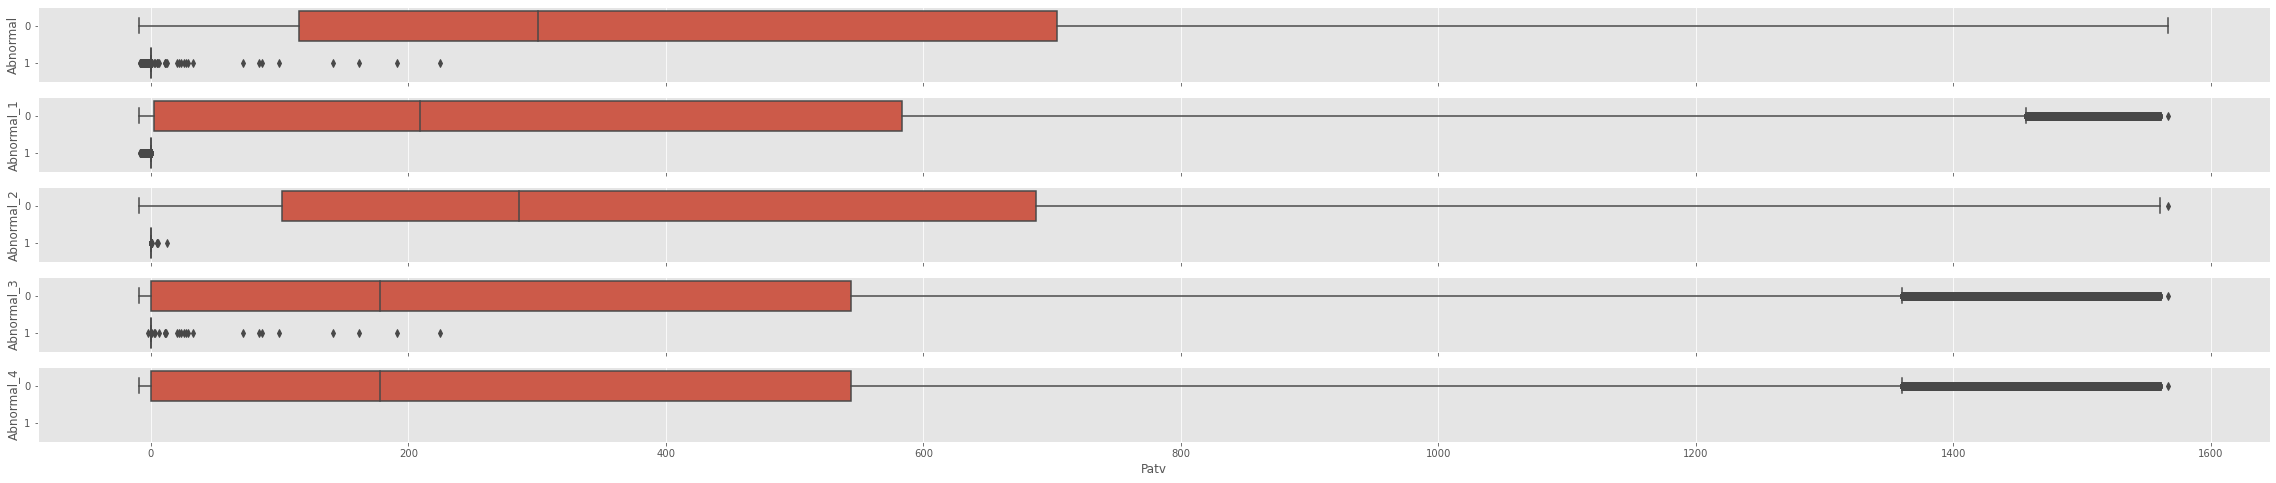

In [5]:
data1 = generate_datetime(data_raw)
save_data(data1, "data1")

data2 = mark_abnormal_Patv(data1)
save_data(data2, "data2")

data3 = manual_handling(data2)
save_data(data3, "data3")

data3

In [ ]:
# tmp = data3
# eda.plot_two_features(tmp, 'Wspd', 'Patv', alpha=1)

In [ ]:
# eda.plot_features_target(data[cols_raw], target, alpha=0.01)
# eda.plot_features_target(data2[cols_raw], target, alpha=0.01)
# eda.plot_features_target(data3, target, alpha=0.01)

In [ ]:
# cols = cols_raw.drop(['TurbID', 'Pab2', 'Pab3'])

# eda.plot_ts_features(data3.query("TurbID == 1")[cols])
# eda.plot_ts_features(data3.query("TurbID == 2")[cols])
# eda.plot_ts_features(data3.query("TurbID == 67")[cols])

In [6]:
def outlier_handling(data, columns):
    @delayed
    def task(data_tid, window_size):
        for day in data_tid['Day'].unique():
            for column in columns:
                temp = data_tid.loc[(day <= data_tid['Day']) & (data_tid['Day'] <= day + window_size - 1), [column]]
                temp[f'{column}_diff'] = temp[column].diff(1)
                for col in (column, f'{column}_diff'):
                    stats = boxplot_stats(temp.dropna()[col])[0]
                    temp[col].where((stats['whislo'] <= temp[col]) & (temp[col] <= stats['whishi']), np.nan, inplace=True)
                temp.drop(columns=[f'{column}_diff'], inplace=True)
                data_tid.loc[temp.index, [column]] = temp.values
        return data_tid
    
    data = data.copy()
    tasks = [task(data[data['TurbID'] == turbID], window_size=2) for turbID in data['TurbID'].unique()]
    with ProgressBar():
        data_tids = compute(*tasks, scheduler='processes')
    
    for data_tid in tqdm(data_tids):
        data.loc[data_tid.index] = data_tid.values
    
    check_nan(data, "Outlier handling")
    return data

In [9]:
data4 = outlier_handling(data3, ['Etmp', 'Itmp'])
save_data(data4, 'data4')
data4

[########################################] | 100% Completed |  1min  3.9s


100%|██████████| 134/134 [01:24<00:00,  1.58it/s]


* Data name: Outlier handling
  - Number of rows: 4688928
  - Number of nan rows: 407243


,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Date,Time,Abnormal,Abnormal_1,Abnormal_2,Abnormal_3,Abnormal_4
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01 00:00:00,1,1,0,0,0,1
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2021-01-01 00:10:00,2,0,0,0,0,0
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,2021-01-01 00:20:00,3,0,0,0,0,0
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,2021-01-01 00:30:00,4,0,0,0,0,0
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,2021-01-01 00:40:00,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688923,134,243,23:10,10.98,-1.96,-5.11,-0.67,345.57,8.82,8.82,8.82,136.49,1152.60,2021-08-31 23:10:00,34988,0,0,0,0,0
4688924,134,243,23:20,11.82,-3.18,-5.46,-0.54,345.57,13.87,13.87,13.87,84.43,681.65,2021-08-31 23:20:00,34989,0,0,0,0,0
4688925,134,243,23:30,11.91,-1.42,-5.21,-0.42,345.57,10.69,10.69,10.69,145.72,1118.35,2021-08-31 23:30:00,34990,0,0,0,0,0
4688926,134,243,23:40,11.86,-0.95,-5.40,-0.38,345.57,13.94,13.94,13.94,89.56,683.49,2021-08-31 23:40:00,34991,0,0,0,0,0


In [ ]:
# eda.plot_missing_value(data4[cols_raw])

In [ ]:
# cols = cols_raw.drop(['TurbID', 'Pab2', 'Pab3'])

# eda.plot_ts_features(data4.query("TurbID == 1")[cols])
# eda.plot_ts_features(data4.query("TurbID == 2")[cols])
# eda.plot_ts_features(data4.query("TurbID == 67")[cols])

In [ ]:
# eda.plot_features_target(data4[cols_raw], target, alpha=0.01)

In [10]:
def find_neighbor(data, col, my_TurbID, plot=False):
    df = pd.DataFrame()
    for turbID in data['TurbID'].unique():
        df[turbID] = data[data['TurbID'] == turbID][col].values
    res = df - df[[my_TurbID]].values
    mae = res.abs().mean()
    rst = mae.drop(my_TurbID).idxmin()
    if plot:
        fig, (ax1, ax2) = plt.subplots(2, figsize=(40, 5))
        mae.plot.bar(ax=ax1)
        df[[my_TurbID, rst]].plot(ax=ax2)
    return rst

def get_dists_loc(input_dir):
    from sklearn.metrics.pairwise import euclidean_distances

    loc = pd.read_csv(join(input_dir, 'turb_location.csv')).set_index('TurbID')
    tids = loc.index
    dists_loc = np.full((len(loc)+1, len(loc)+1), np.inf)
    for i1 in range(len(loc)-1):
        for i2 in range(i1+1, len(loc)):
            t1, t2 = tids[i1], tids[i2]
            dists_loc[i1, i2] = euclidean_distances([loc.loc[t1].values], [loc.loc[t2].values])
    return dists_loc

def greedy_imputing(data, tids=None, k=10, verbose=False):
    def greedy_imputing_tid(data, tid_target, dists_loc, k, verbose):
        def affinity(tid):
            d        = data[data['TurbID'] == tid][cols].values
            d_target = data[data['TurbID'] == tid_target][cols].values
            diff = np.abs(d - d_target)
            return diff[~np.isnan(diff)].mean()
        
        cols       = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']
        neighbors  = [tid for tid, dist_loc in sorted(enumerate(dists_loc[tid_target], start=1), key=lambda x: x[1])[:k]]
        n_nan_prev = np.sum(data.loc[data['TurbID'] == tid_target, cols].isna().values)

        for tid in sorted(neighbors, key=affinity):
            a = data.loc[data['TurbID'] == tid_target, cols].values
            b = data.loc[data['TurbID'] == tid, cols].values
            data.loc[data['TurbID'] == tid_target, cols] = np.where(np.isnan(a) & (~np.isnan(b)), b, a)

        n_nan_after = np.sum(data[data['TurbID'] == tid_target].isna().values)
        if verbose and n_nan_after < n_nan_prev:
            print(f"[TurbID {tid_target}] Number of nan: {n_nan_prev} -> {n_nan_after}")
        return n_nan_after < n_nan_prev

    data = copy(data)
    dists_loc = get_dists_loc(PATH.input)

    if tids is None:
        tids = data['TurbID'].unique()

    while True:
        rsts = {}
        for tid in tqdm(tids):
            rsts[tid] = greedy_imputing_tid(data, tid, dists_loc, k, verbose)
        if not any(rsts.values()) or (k == 134):
            break

    check_nan(data, "Greedy imputing")
    return data


def impute_data(data, threshold=6 * 12, drop=False):
    data = copy(data)
    data_imp = pd.DataFrame()
    for turbID in tqdm(data['TurbID'].unique()):
        data_tid = data[data['TurbID'] == turbID]
        idxs = (data_tid.isna().sum(axis='columns') > 0)
        idxs_nan = idxs[idxs].index
        idxs_removed = []

        if len(idxs_nan) > 0:
            s, e = 0, 1
            while e < len(idxs_nan):
                cur = idxs_nan[s:e]
                if idxs_nan[e] == cur[-1] + 1:
                    e += 1
                else:
                    if len(cur) >= threshold:
                        idxs_removed += list(cur)
                    s = e
                    e = s + 1
            else:
                if len(cur) >= threshold:
                    idxs_removed += list(cur)

        data_tid_drop = data_tid.drop(idxs_removed)
        tmp = data.isna().sum()
        cols_nan = tmp[tmp > 0].index
        data_tid_drop[cols_nan] = data_tid_drop[cols_nan].interpolate().bfill().ffill()
        if drop:
            data_tid_imp = data_tid_drop
        else:
            data_tid_imp = data_tid
            data_tid_imp.loc[data_tid_drop.index] = data_tid_drop.values
        data_imp = data_imp.append(data_tid_imp)

    check_nan(data_imp, "Imputing")
    return data_imp.reset_index(drop=True)

In [11]:
data5 = greedy_imputing(data4, tids=[2, 7, 8, 9, 13, 18, 24, 25, 26, 29, 30, 33, 36, 38, 40, 41, 50, 54, 60, 61, 65, 66, 67, 68, 79, 80, 82, 87, 88, 105, 118, 121, 122, 126, 129], k=20)
save_data(data5, 'data5')

data6 = impute_data(data5)
save_data(data6, 'data6')

100%|██████████| 35/35 [01:52<00:00,  3.21s/it]


* Data name: Greedy imputing
  - Number of rows: 4688928
  - Number of nan rows: 115986


100%|██████████| 134/134 [01:26<00:00,  1.54it/s]


* Data name: Imputing
  - Number of rows: 4688928
  - Number of nan rows: 31841


In [ ]:
# data6 = pd.read_csv(join(PATH.input, 'data6.csv'))

In [ ]:
eda.plot_missing_value(data6)
# eda.plot_features_target(data6, target, alpha=0.002)

In [ ]:
for tid in data6['TurbID'].unique():
    data = data6.query(f"TurbID == {tid}")
    data_nan = data[data.isna().any(1)]
    
    print("TurbID:", tid)
    display(data_nan.groupby("Day").count()['Time'].to_frame().T.style.background_gradient(axis=1))

In [ ]:
cols = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Prtv', 'Patv']
for tid in data6['TurbID'].unique():
    data = data6.query(f"TurbID == {tid}")[cols]
    eda.plot_ts_features(data, title=f"TurbID={tid}", figsize=(40, 8))

In [12]:
data_imp = data6

In [13]:
def feature_engineering(data):
    data = copy(data)
    
    # 1. EDA features
    data['Wspd_active']  = data['Wspd'] - 1
    data['Wspd_extreme'] = data['Wspd'] < 1
    data['Wspd_comb']    = data['Wspd_extreme'] * data['Wspd_active']
    
    data['Wdir_active']  = data['Wdir'].abs() - 10
    data['Wdir_extreme'] = data['Wdir'].abs() > 10
    data['Wdir_comb']    = data['Wdir_extreme'] * data['Wdir_active']
    
    Ndir_rad             = data['Ndir']
    data['Ndir_cos']     = np.cos(Ndir_rad)  # 0도, 180도, 360도
#     data['Ndir_180']     = data['Ndir'].map(lambda x: np.min([abs(x-0), abs(x-180), abs(x-360)]))  # -180은 안 됨
    data['Ndir_extreme'] = data['Ndir'] < -90  # -180은 안 됨
    data['Ndir_comb']    = data['Ndir_extreme'] * data['Ndir_cos']

    data['Pab']          = (data['Pab1'] + data['Pab2'] + data['Pab3'])/3
    data['Pab_extreme1'] = data['Pab'] < 0.03
    data['Pab_extreme2'] = data['Pab'] > 20

    data['Prtv_pos']     = data['Prtv'] > 0
    data['Prtv_abs']     = data['Prtv'].abs()
    data['Prtv_comb']    = data['Prtv_pos'] * data['Prtv_abs']
    
    
    # 2. Time
    DAY = 6*24  # 10minute * 6 * 24hour
    Time_in_day     = data['Time'] * (2*np.pi) / DAY
    data['Day_cos'] = np.cos(Time_in_day)
    data['Day_sin'] = np.sin(Time_in_day)

    YEAR = 365*DAY
    Time_in_year     = data['Time'] * (2*np.pi) / YEAR
    data['Year_cos'] = np.cos(Time_in_year)
    data['Year_sin'] = np.sin(Time_in_year)
    data['Weekday']  = data['Day'] % 7
    
    # 3. Direction
    Wdir_rad         = np.radians(data['Wdir'])
    data['Wdir_cos'] = np.cos(Wdir_rad)
    data['Wdir_sin'] = np.sin(Wdir_rad)
    data['Wspd_cos'] = data['Wspd_active'] * np.cos(Wdir_rad)
    data['Wspd_sin'] = data['Wspd_active'] * np.sin(Wdir_rad)
    
#     data['Ndir_cos'] = np.cos(Ndir_rad)
    data['Ndir_sin'] = np.sin(Ndir_rad)
    
    # 4. RPM
    ALPHA = 40
    Pab_rad     = np.radians(data['Pab']+ALPHA)
    data['TSR'] = 1 / np.tan(Pab_rad)
    data['RPM'] = data['Wspd_active'] * data['TSR']
    
    # 5. Patv
    data['Wspd_cube'] = data['Wspd_active']**3
    min_val = data[data['Patv'] > 0]['Patv'].min()
    data['Patv_pos']  = np.maximum(data['Patv'], min_val)
    data['Patan_abs'] = np.arctan(data['Prtv_abs'] / data['Patv_pos'])
    
    return data

def feature_engineering_lag(data, cols, lags):
    data = copy(data)
    for turbID in tqdm(data['TurbID'].unique()):
        data_tid = data[data['TurbID'] == turbID]
        for lag in lags:
            data.loc[data_tid.index, [f'{col}_LAG{lag}' for col in cols]] = data_tid[cols].shift(144*lag).values
#             data.loc[data_tid.index, [f'{col}_MA{lag}' for col in cols]]  = data_tid[cols].rolling(144*lag).mean().values
    data = data[data['Day'] > max(lags)]
    check_nan(data, "Feature engineering2")
    return data

In [14]:
data_fe = feature_engineering(data_imp)
data_fe

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Date,Time,Abnormal,Abnormal_1,Abnormal_2,Abnormal_3,Abnormal_4,Wspd_active,Wspd_extreme,Wspd_comb,Wdir_active,Wdir_extreme,Wdir_comb,Ndir_cos,Ndir_extreme,Ndir_comb,Pab,Pab_extreme1,Pab_extreme2,Prtv_pos,Prtv_abs,Prtv_comb,Day_cos,Day_sin,Year_cos,Year_sin,Weekday,Wdir_cos,Wdir_sin,Wspd_cos,Wspd_sin,Ndir_sin,TSR,RPM,Wspd_cube,Patv_pos,Patan_abs
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2021-01-01 00:00:00,1,1,0,0,0,1,5.17,False,0.0,-6.01,False,-0.0,0.705790,False,0.0,1.00,False,False,False,0.25,0.00,0.999048,4.361939e-02,1.000000,0.000120,1,0.997576,-0.069582,5.157469,-0.359741,0.708421,1.150368,5.947405,138.188413,494.66,0.000505
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2021-01-01 00:10:00,2,0,0,0,0,0,5.17,False,0.0,-6.01,False,-0.0,0.705790,False,0.0,1.00,False,False,False,0.25,0.00,0.996195,8.715574e-02,1.000000,0.000239,1,0.997576,-0.069582,5.157469,-0.359741,0.708421,1.150368,5.947405,138.188413,494.66,0.000505
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,2021-01-01 00:20:00,3,0,0,0,0,0,5.27,False,0.0,-7.82,False,-0.0,-0.470315,False,-0.0,1.00,False,False,False,0.24,0.00,0.991445,1.305262e-01,1.000000,0.000359,1,0.999276,-0.038039,5.266186,-0.200466,0.882499,1.150368,6.062442,146.363183,509.76,0.000471
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,2021-01-01 00:30:00,4,0,0,0,0,0,5.42,False,0.0,-9.27,False,-0.0,-0.470315,False,-0.0,1.00,False,False,False,0.26,0.00,0.984808,1.736482e-01,1.000000,0.000478,1,0.999919,-0.012741,5.419560,-0.069054,0.882499,1.150368,6.234997,159.220088,542.53,0.000479
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,2021-01-01 00:40:00,5,0,0,0,0,0,5.25,False,0.0,-9.11,False,-0.0,-0.470315,False,-0.0,1.00,False,False,False,0.23,0.00,0.976296,2.164396e-01,1.000000,0.000598,1,0.999879,0.015533,5.249367,0.081547,0.882499,1.150368,6.039434,144.703125,509.36,0.000452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688923,134,243,23:10,10.98,-1.96,-5.11,-0.67,345.57,8.82,8.82,8.82,136.49,1152.60,2021-08-31 23:10:00,34988,0,0,0,0,0,9.98,False,0.0,-8.04,False,-0.0,0.999987,False,0.0,8.82,False,False,True,136.49,136.49,0.984808,-1.736482e-01,-0.505374,-0.862901,5,0.999415,-0.034202,9.974161,-0.341334,-0.005192,0.874817,8.730678,994.011992,1152.60,0.117870
4688924,134,243,23:20,11.82,-3.18,-5.46,-0.54,345.57,13.87,13.87,13.87,84.43,681.65,2021-08-31 23:20:00,34989,0,0,0,0,0,10.82,False,0.0,-6.82,False,-0.0,0.999987,False,0.0,13.87,False,False,True,84.43,84.43,0.991445,-1.305262e-01,-0.505271,-0.862961,5,0.998460,-0.055473,10.803339,-0.600218,-0.005192,0.730015,7.898761,1266.723368,681.65,0.123234
4688925,134,243,23:30,11.91,-1.42,-5.21,-0.42,345.57,10.69,10.69,10.69,145.72,1118.35,2021-08-31 23:30:00,34990,0,0,0,0,0,10.91,False,0.0,-8.58,False,-0.0,0.999987,False,0.0,10.69,False,False,True,145.72,145.72,0.996195,-8.715574e-02,-0.505167,-0.863021,5,0.999693,-0.024781,10.906650,-0.270362,-0.005192,0.818782,8.932912,1298.596571,1118.35,0.129569
4688926,134,243,23:40,11.86,-0.95,-5.40,-0.38,345.57,13.94,13.94,13.94,89.56,683.49,2021-08-31 23:40:00,34991,0,0,0,0,0,10.86,False,0.0,-9.05,False,-0.0,0.999987,False,0.0,13.94,False,False,True,89.56,89.56,0.999048,-4.361939e-02,-0.505064,-0.863082,5,0.999863,-0.016580,10.858507,-0.180057,-0.005192,0.728144,7.907641,1280.824056,683.49,0.130291


In [58]:
cols_sel = ['TurbID', 'Day', 'Time']
cols_sel += ['Etmp', 'Itmp', 'Prtv', 
             'Wspd', 'Wspd_extreme', 'Wspd_comb', 
             'Wdir_active', 'Wdir_extreme', 'Wdir_comb', 
             'Ndir_cos', 'Ndir_sin', 'Ndir_extreme', 'Ndir_comb', 
             'Pab', 'Pab_extreme1', 'Pab_extreme2', 
             'Prtv_pos', 'Prtv_abs', 'Prtv_comb', 
             'Wdir_cos', 'Wdir_sin', 'Wspd_cos', 'Wspd_sin', 
             'RPM', 'Wspd_cube', 
             'Patan_abs']
cols_sel += ['Day_cos', 'Day_sin', 'Year_cos', 'Year_sin']
cols_sel += [target]
cols_sel

['TurbID',
 'Day',
 'Time',
 'Etmp',
 'Itmp',
 'Prtv',
 'Wspd',
 'Wspd_extreme',
 'Wspd_comb',
 'Wdir_active',
 'Wdir_extreme',
 'Wdir_comb',
 'Ndir_cos',
 'Ndir_sin',
 'Ndir_extreme',
 'Ndir_comb',
 'Pab',
 'Pab_extreme1',
 'Pab_extreme2',
 'Prtv_pos',
 'Prtv_abs',
 'Prtv_comb',
 'Wdir_cos',
 'Wdir_sin',
 'Wspd_cos',
 'Wspd_sin',
 'RPM',
 'Wspd_cube',
 'Patan_abs',
 'Day_cos',
 'Day_sin',
 'Year_cos',
 'Year_sin',
 'Patv']

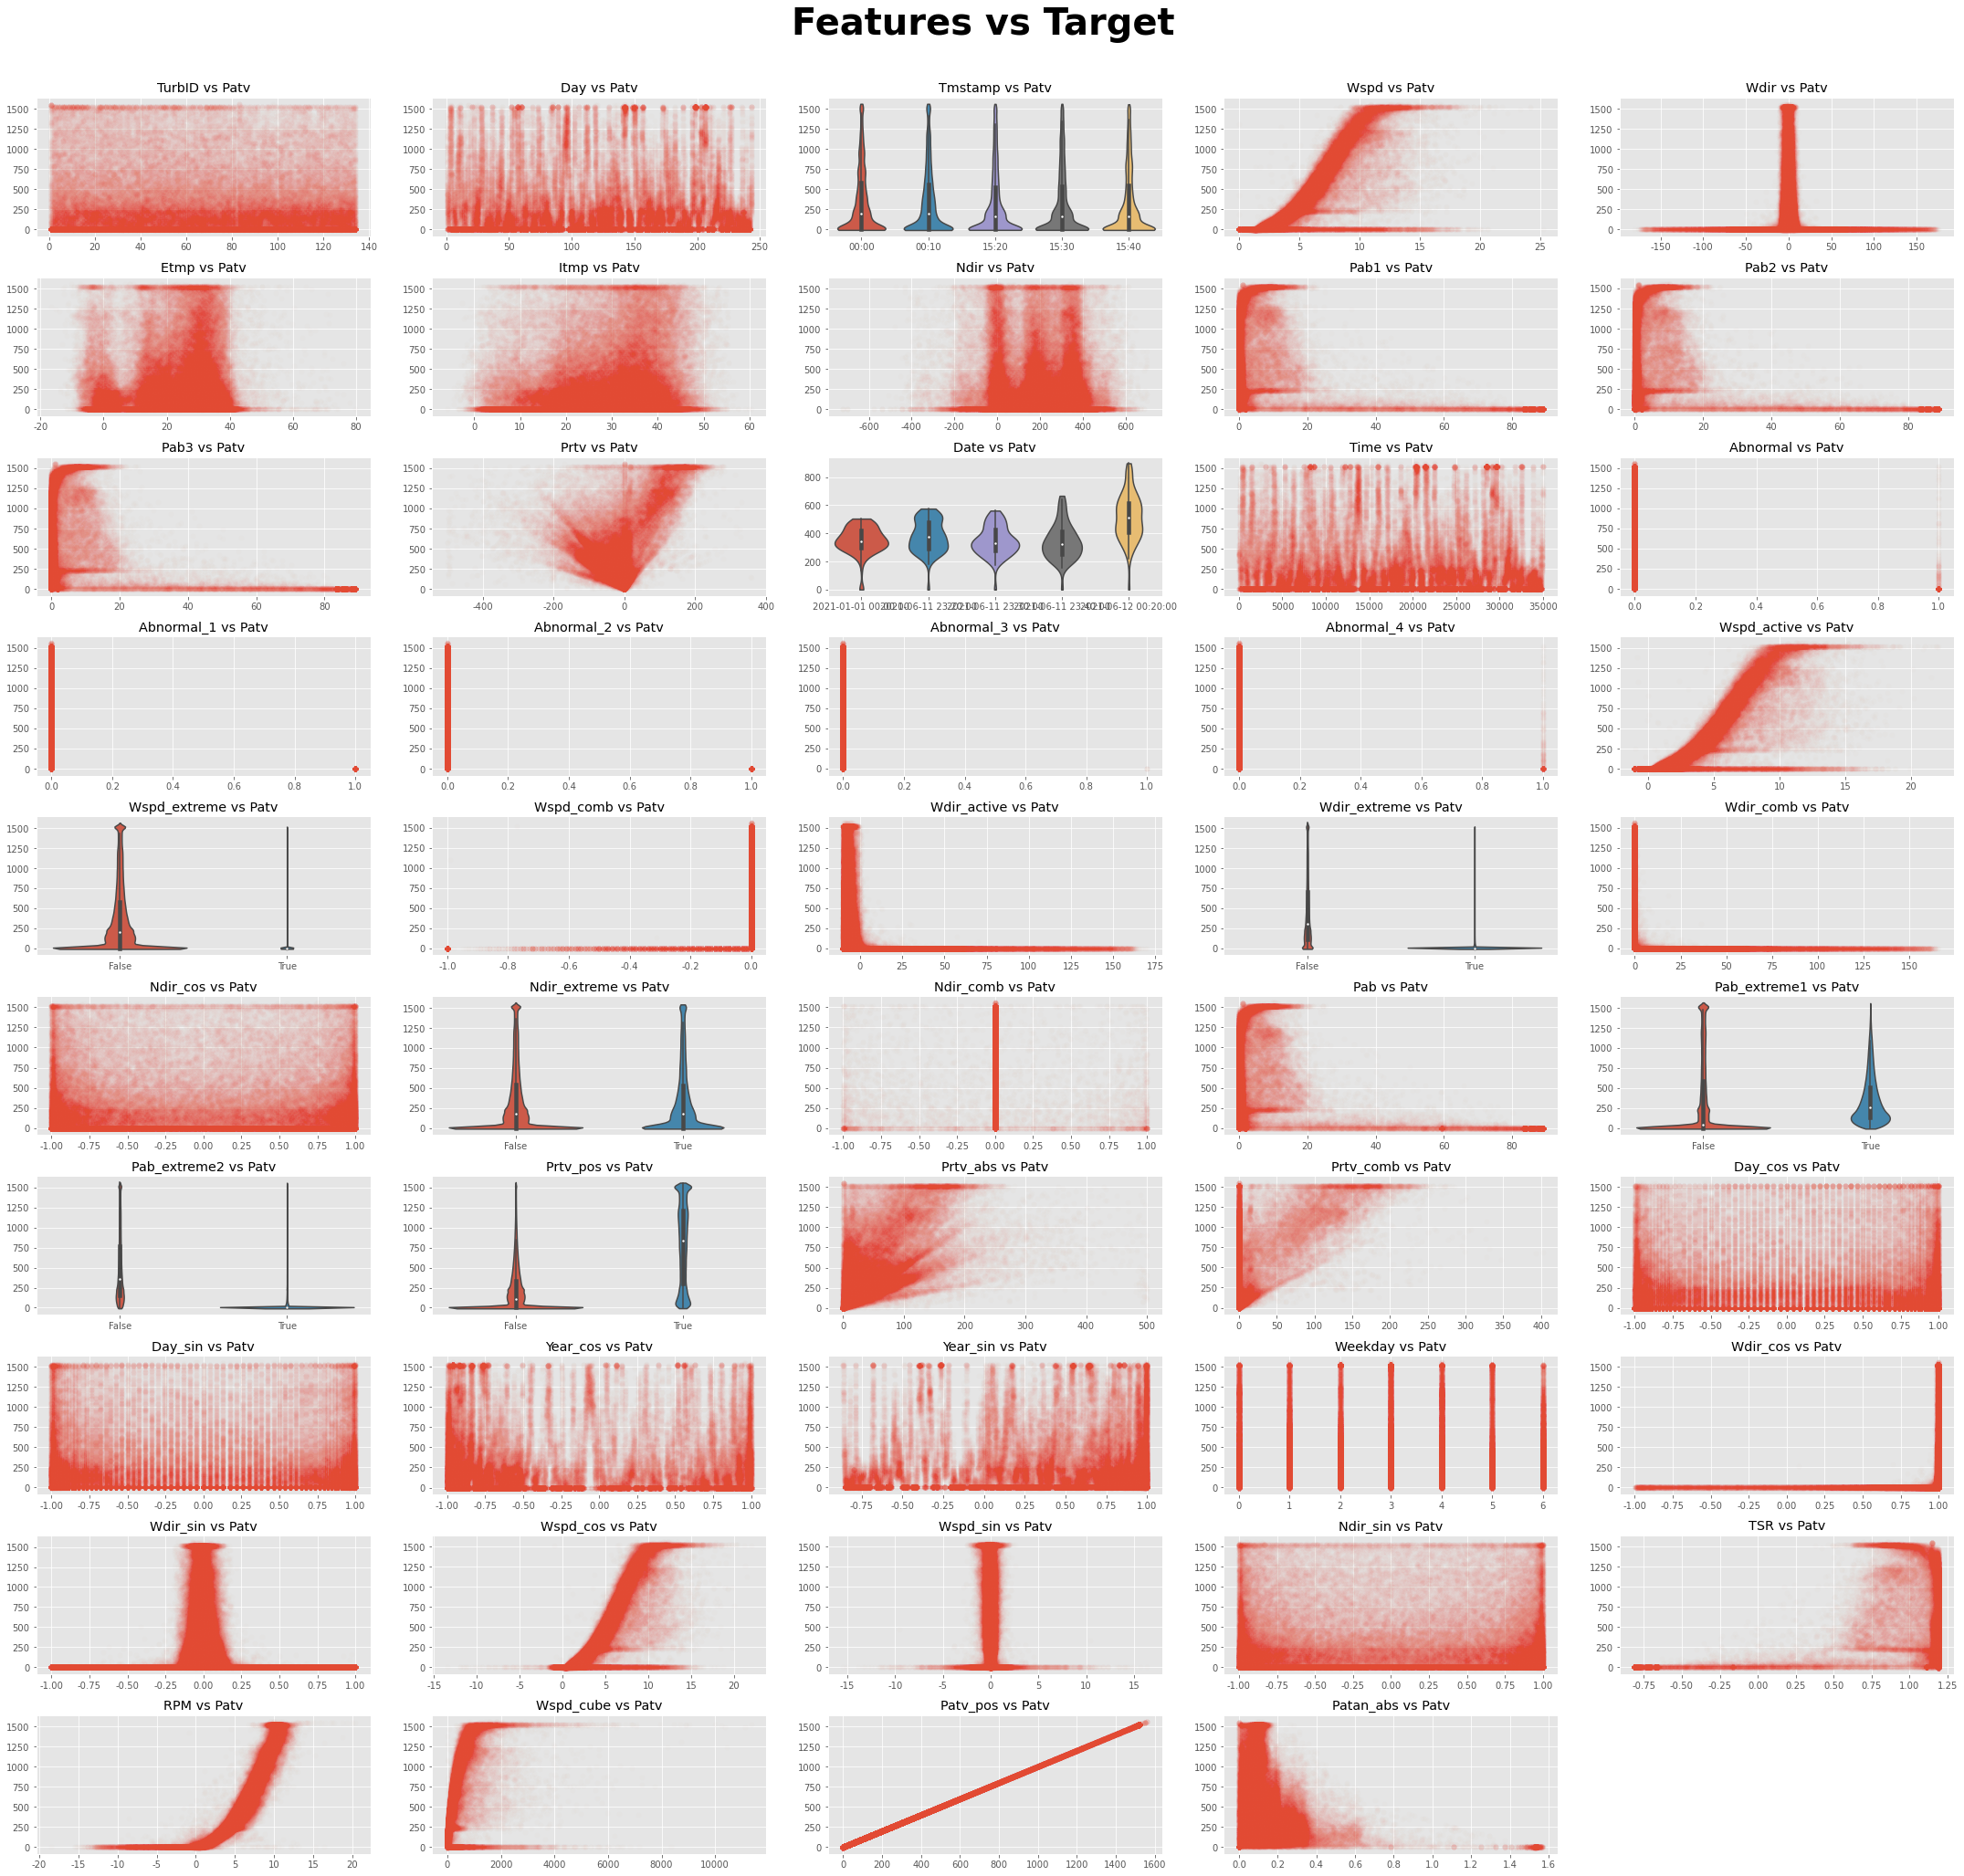

In [16]:
eda.plot_features_target(data_fe, target, alpha=0.01, figsize=(30, 30))

In [ ]:
eda.plot_corr(data_raw.corr(), data_fe.corr(), figsize=(20, 20))

In [59]:
data_sel = data_fe[cols_sel]
data_sel

,TurbID,Day,Time,Etmp,Itmp,Prtv,Wspd,Wspd_extreme,Wspd_comb,Wdir_active,Wdir_extreme,Wdir_comb,Ndir_cos,Ndir_sin,Ndir_extreme,Ndir_comb,Pab,Pab_extreme1,Pab_extreme2,Prtv_pos,Prtv_abs,Prtv_comb,Wdir_cos,Wdir_sin,Wspd_cos,Wspd_sin,RPM,Wspd_cube,Patan_abs,Day_cos,Day_sin,Year_cos,Year_sin,Patv
0,1,1,1,30.73,41.80,-0.25,6.17,False,0.0,-6.01,False,-0.0,0.705790,0.708421,False,0.0,1.00,False,False,False,0.25,0.00,0.997576,-0.069582,5.157469,-0.359741,5.947405,138.188413,0.000505,0.999048,4.361939e-02,1.000000,0.000120,494.66
1,1,1,2,30.73,41.80,-0.25,6.17,False,0.0,-6.01,False,-0.0,0.705790,0.708421,False,0.0,1.00,False,False,False,0.25,0.00,0.997576,-0.069582,5.157469,-0.359741,5.947405,138.188413,0.000505,0.996195,8.715574e-02,1.000000,0.000239,494.66
2,1,1,3,30.60,41.63,-0.24,6.27,False,0.0,-7.82,False,-0.0,-0.470315,0.882499,False,-0.0,1.00,False,False,False,0.24,0.00,0.999276,-0.038039,5.266186,-0.200466,6.062442,146.363183,0.000471,0.991445,1.305262e-01,1.000000,0.000359,509.76
3,1,1,4,30.52,41.52,-0.26,6.42,False,0.0,-9.27,False,-0.0,-0.470315,0.882499,False,-0.0,1.00,False,False,False,0.26,0.00,0.999919,-0.012741,5.419560,-0.069054,6.234997,159.220088,0.000479,0.984808,1.736482e-01,1.000000,0.000478,542.53
4,1,1,5,30.49,41.38,-0.23,6.25,False,0.0,-9.11,False,-0.0,-0.470315,0.882499,False,-0.0,1.00,False,False,False,0.23,0.00,0.999879,0.015533,5.249367,0.081547,6.039434,144.703125,0.000452,0.976296,2.164396e-01,1.000000,0.000598,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688923,134,243,34988,-5.11,-0.67,136.49,10.98,False,0.0,-8.04,False,-0.0,0.999987,-0.005192,False,0.0,8.82,False,False,True,136.49,136.49,0.999415,-0.034202,9.974161,-0.341334,8.730678,994.011992,0.117870,0.984808,-1.736482e-01,-0.505374,-0.862901,1152.60
4688924,134,243,34989,-5.46,-0.54,84.43,11.82,False,0.0,-6.82,False,-0.0,0.999987,-0.005192,False,0.0,13.87,False,False,True,84.43,84.43,0.998460,-0.055473,10.803339,-0.600218,7.898761,1266.723368,0.123234,0.991445,-1.305262e-01,-0.505271,-0.862961,681.65
4688925,134,243,34990,-5.21,-0.42,145.72,11.91,False,0.0,-8.58,False,-0.0,0.999987,-0.005192,False,0.0,10.69,False,False,True,145.72,145.72,0.999693,-0.024781,10.906650,-0.270362,8.932912,1298.596571,0.129569,0.996195,-8.715574e-02,-0.505167,-0.863021,1118.35
4688926,134,243,34991,-5.40,-0.38,89.56,11.86,False,0.0,-9.05,False,-0.0,0.999987,-0.005192,False,0.0,13.94,False,False,True,89.56,89.56,0.999863,-0.016580,10.858507,-0.180057,7.907641,1280.824056,0.130291,0.999048,-4.361939e-02,-0.505064,-0.863082,683.49


In [97]:
data_sel = feature_engineering_lag(data_sel, data_sel.columns.drop(["TurbID", 'Day', 'Time']), lags=[5])
data_sel

100%|██████████| 134/134 [01:05<00:00,  2.05it/s]


* Data name: Feature engineering2
  - Number of rows: 4592448
  - Number of nan rows: 63682


,TurbID,Day,Time,Etmp,Itmp,Prtv,Wspd,Wspd_extreme,Wspd_comb,Wdir_active,Wdir_extreme,Wdir_comb,Ndir_cos,Ndir_sin,Ndir_extreme,Ndir_comb,Pab,Pab_extreme1,Pab_extreme2,Prtv_pos,Prtv_abs,Prtv_comb,Wdir_cos,Wdir_sin,Wspd_cos,Wspd_sin,RPM,Wspd_cube,Patan_abs,Day_cos,Day_sin,Year_cos,Year_sin,Patv,Etmp_LAG5,Itmp_LAG5,Prtv_LAG5,Wspd_LAG5,Wspd_extreme_LAG5,Wspd_comb_LAG5,Wdir_active_LAG5,Wdir_extreme_LAG5,Wdir_comb_LAG5,Ndir_cos_LAG5,Ndir_sin_LAG5,Ndir_extreme_LAG5,Ndir_comb_LAG5,Pab_LAG5,Pab_extreme1_LAG5,Pab_extreme2_LAG5,Prtv_pos_LAG5,Prtv_abs_LAG5,Prtv_comb_LAG5,Wdir_cos_LAG5,Wdir_sin_LAG5,Wspd_cos_LAG5,Wspd_sin_LAG5,RPM_LAG5,Wspd_cube_LAG5,Patan_abs_LAG5,Day_cos_LAG5,Day_sin_LAG5,Year_cos_LAG5,Year_sin_LAG5,Patv_LAG5
720,1,6,721,21.05,33.05,-0.26,6.12,False,0.0,-9.07,False,-0.0,0.695806,0.718230,False,0.0,1.00,False,False,False,0.26,0.00,0.999868,0.016231,5.119326,0.083102,5.889886,134.217728,0.000477,0.999048,4.361939e-02,0.996288,0.086084,545.13,30.73,41.80,-0.25,6.17,0.0,0.0,-6.01,0.0,-0.0,0.705790,0.708421,0.0,0.0,1.00,0.0,0.0,0.0,0.25,0.00,0.997576,-0.069582,5.157469,-0.359741,5.947405,138.188413,0.000505,0.999048,4.361939e-02,1.000000,0.000120,494.66
721,1,6,722,20.90,33.19,-0.25,6.98,False,0.0,-9.33,False,-0.0,0.695806,0.718230,False,0.0,1.00,False,False,False,0.25,0.00,0.999932,0.011693,5.979591,0.069927,6.879203,213.847192,0.000339,0.996195,8.715574e-02,0.996278,0.086203,736.93,30.73,41.80,-0.25,6.17,0.0,0.0,-6.01,0.0,-0.0,0.705790,0.708421,0.0,0.0,1.00,0.0,0.0,0.0,0.25,0.00,0.997576,-0.069582,5.157469,-0.359741,5.947405,138.188413,0.000505,0.996195,8.715574e-02,1.000000,0.000239,494.66
722,1,6,723,20.80,33.20,-0.25,8.99,False,0.0,-6.65,False,-0.0,0.695806,0.718230,False,0.0,1.00,False,False,False,0.25,0.00,0.998291,0.058435,7.976347,0.466897,9.191444,510.082399,0.000216,0.991445,1.305262e-01,0.996267,0.086322,1159.05,30.60,41.63,-0.24,6.27,0.0,0.0,-7.82,0.0,-0.0,-0.470315,0.882499,0.0,-0.0,1.00,0.0,0.0,0.0,0.24,0.00,0.999276,-0.038039,5.266186,-0.200466,6.062442,146.363183,0.000471,0.991445,1.305262e-01,1.000000,0.000359,509.76
723,1,6,724,20.75,33.09,-0.30,8.50,False,0.0,-9.00,False,-0.0,0.916350,-0.400378,False,0.0,1.00,False,False,False,0.30,0.00,0.999848,0.017452,7.498858,0.130893,8.627763,421.875000,0.000287,0.984808,1.736482e-01,0.996257,0.086441,1046.77,30.52,41.52,-0.26,6.42,0.0,0.0,-9.27,0.0,-0.0,-0.470315,0.882499,0.0,-0.0,1.00,0.0,0.0,0.0,0.26,0.00,0.999919,-0.012741,5.419560,-0.069054,6.234997,159.220088,0.000479,0.984808,1.736482e-01,1.000000,0.000478,542.53
724,1,6,725,20.66,33.16,-0.25,7.82,False,0.0,-8.21,False,-0.0,-0.861021,0.508569,False,-0.0,1.00,False,False,False,0.25,0.00,0.999512,0.031236,6.816672,0.213032,7.845513,317.214568,0.000275,0.976296,2.164396e-01,0.996247,0.086560,909.39,30.49,41.38,-0.23,6.25,0.0,0.0,-9.11,0.0,-0.0,-0.470315,0.882499,0.0,-0.0,1.00,0.0,0.0,0.0,0.23,0.00,0.999879,0.015533,5.249367,0.081547,6.039434,144.703125,0.000452,0.976296,2.164396e-01,1.000000,0.000598,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688923,134,243,34988,-5.11,-0.67,136.49,10.98,False,0.0,-8.04,False,-0.0,0.999987,-0.005192,False,0.0,8.82,False,False,True,136.49,136.49,0.999415,-0.034202,9.974161,-0.341334,8.730678,994.011992,0.117870,0.984808,-1.736482e-01,-0.505374,-0.862901,1152.60,-2.54,1.18,7.60,2.09,0.0,0.0,-9.63,0.0,-0.0,0.661432,0.750005,0.0,0.0,0.01,1.0,0.0,1.0,7.60,7.60,0.999979,0.006458,1.089977,0.007039,1.298551,1.295029,0.171729,0.984808,-1.736482e-01,-0.577682,-0.816262,43.82
4688924,134,243,34989,-5.46,-0.54,84.43,11.82,False,0.0,-6.82,False,-0.0,0.999987,-0.005192,False,0.0,13.87,False,False,True,84.43,84.43,0.998460,-0.055473,10.803339,-0.600218,7.898761,1266.723368,0.123234,0.991445,-1.305262e-01,-0.505271,-0.862961,681.65,-2.60,1.08,8.24,2.29,0.0,0.0,-7.36,0.0,-0

# 4. Modeling

In [70]:
from tensorflow import keras
from tensorflow.keras.utils import timeseries_dataset_from_array
from analysis_tools import preprocessing

def print_shape(*args):
    print("* Shape of dataset")
    for arg in args:
        print(f"  - {arg.shape}")

def drop_missing_data(X, y):
    X_new, y_new = [], []
    for X_s, y_s in zip(X, y):
        if (np.isnan(X_s).sum() == 0) and (np.isnan(y_s).sum() == 0):
            X_new.append(X_s)
            y_new.append(y_s)
    return np.array(X_new), np.array(y_new)

def sliding_window(df, in_seq_len, out_seq_len, stride):
    X_df = df.iloc[:-out_seq_len]
    y_df = df.iloc[in_seq_len:]

    Xs = []
    ys = []
    for i in range(0, len(df) - in_seq_len - out_seq_len + 1, stride):
        X = X_df.iloc[i:i + in_seq_len]
        y = y_df.iloc[i:i + out_seq_len]
        if (X.isnull().values.any()) or (y.isnull().values.any()):
            continue
        Xs.append(X.values)
        ys.append(y.values)
    return np.array(Xs), np.array(ys)

def Xy_from_dataframe(df, in_seq_len, out_seq_len, stride):
    df = df.astype('float32')
    if len(df) == in_seq_len:  # test dataframe
        X = [df.values]  # expand_dim
        y = None
        X, _ = drop_missing_data(X, X)
    else:
        X, y = sliding_window(df, in_seq_len, out_seq_len, stride)
        X, y = drop_missing_data(X, y)
    return X, y

def scale(data, scaler):
    if not isinstance(data, np.ndarray):
        data = np.array(data, dtype='float32')
    if len(data.shape) == 3:
        return scaler.transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
    elif len(data.shape) == 2:
        return scaler.transform(data)
    else:
        raise ValueError("len(data.shape) should be 2 or 3")
        
def inverse_scale(data, scaler):
    if len(data.shape) == 3:
        return scaler.inverse_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
    elif len(data.shape) == 2:
        return scaler.inverse_transform(data)
    else:
        raise ValueError("len(data.shape) should be 2 or 3")

In [ ]:
# cols   = data_sel.columns.drop(['Day', 'Time'])
# cols_X = data_sel.columns.drop(['Day', 'Time'])
# cols_y = ['Wspd_active', 'Patv']  # ['Etmp', 'Itmp', 'Prtv', 'Wspd_active', 'Wdir', 'Ndir', 'Pab', 'Patv']
# idx_cols_y = [i for i, col in enumerate(cols_X) if col in cols_y]

# IN_SEQ_LEN  = 2*144
# OUT_SEQ_LEN = 2*144
# STRIDE      = 144

# n_tids = data_sel['TurbID'].nunique()
# train_X, train_y = n_tids*[None], n_tids*[None]
# val_X,   val_y   = n_tids*[None], n_tids*[None]
# test_X,  test_y  = n_tids*[None], n_tids*[None]

# train_data = data_sel[data_sel['Day'] <= 200]
# val_data   = data_sel[(200 < data_sel['Day']) & (data_sel['Day'] <= 220)]
# test_data  = data_sel[220 < data_sel['Day']]

# for i, tid in tqdm(list(enumerate(data_sel['TurbID'].unique()))):
#     d_train = train_data.loc[train_data['TurbID'] == tid, cols]
#     d_val   = val_data.loc[val_data['TurbID'] == tid, cols]
#     d_test  = test_data.loc[test_data['TurbID'] == tid, cols]
    
#     train_X[i], train_y[i] = Xy_from_dataframe(d_train, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
#     val_X[i],   val_y[i]   = Xy_from_dataframe(d_val, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
#     test_X[i],  test_y[i]  = Xy_from_dataframe(d_test, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)

# train_X = np.concatenate(train_X)
# train_y = np.concatenate(train_y)

# val_X   = np.concatenate(val_X)
# val_y   = np.concatenate(val_y)

# test_X  = np.concatenate(test_X)
# test_y  = np.concatenate(test_y)

# print_shape(train_X, train_y, val_X, val_y, test_X, test_y)

In [ ]:
# from sklearn.model_selection import train_test_split

# cols   = data_sel.columns.drop(['Day', 'Time'])
# cols_X = data_sel.columns.drop(['Day', 'Time'])
# cols_y = ['Wspd_active', 'Patv']  # ['Etmp', 'Itmp', 'Prtv', 'Wspd_active', 'Wdir', 'Ndir', 'Pab', 'Patv']
# idx_cols_y = [i for i, col in enumerate(cols_X) if col in cols_y]

# IN_SEQ_LEN  = 2*144
# OUT_SEQ_LEN = 2*144
# STRIDE      = 2*144

# n_tids = data_sel['TurbID'].nunique()
# train_full_X, train_full_y = n_tids*[None], n_tids*[None]
# test_X,       test_y       = n_tids*[None], n_tids*[None]

# train_full_data = data_sel[data_sel['Day'] <= 220]
# test_data       = data_sel[220 < data_sel['Day']]

# for i, tid in tqdm(list(enumerate(data_sel['TurbID'].unique()))):
#     d_train_full = train_full_data.loc[train_full_data['TurbID'] == tid, cols]
#     d_test       = test_data.loc[test_data['TurbID'] == tid, cols]
    
#     train_full_X[i], train_full_y[i] = Xy_from_dataframe(d_train_full, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
#     test_X[i],       test_y[i]       = Xy_from_dataframe(d_test, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)

# train_full_X = np.concatenate(train_full_X)
# train_full_y = np.concatenate(train_full_y)[..., idx_cols_y]

# test_X = np.concatenate(test_X)
# test_y = np.concatenate(test_y)[..., idx_cols_y]

# train_X, val_X, train_y, val_y = train_test_split(train_full_X, train_full_y, test_size=0.1)

# print_shape(train_X, train_y, val_X, val_y, test_X, test_y)

In [98]:
from sklearn.model_selection import train_test_split

cols   = data_sel.columns.drop(['Day', 'Time'])
cols_X = data_sel.columns.drop(['Day', 'Time'])
cols_y = ['Wspd', 'Patv']  # ['Etmp', 'Itmp', 'Prtv', 'Wspd_active', 'Wdir', 'Ndir', 'Pab', 'Patv']
idx_cols_y = [i for i, col in enumerate(cols_X) if col in cols_y]

IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 2*144

n_tids = data_sel['TurbID'].nunique()
train_full_X, train_full_y = n_tids*[None], n_tids*[None]
test_X,       test_y       = n_tids*[None], n_tids*[None]

train_full_data = data_sel[data_sel['Day'] < 242]
test_data       = data_sel[242 <= data_sel['Day']]

for i, tid in tqdm(list(enumerate(data_sel['TurbID'].unique()))):
    d_train_full = train_full_data.loc[train_full_data['TurbID'] == tid, cols]
    d_test       = test_data.loc[test_data['TurbID'] == tid, cols]
    
    train_full_X[i], train_full_y[i] = Xy_from_dataframe(d_train_full, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
    test_X[i],       _               = Xy_from_dataframe(d_test, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE)
    test_y[i] = [test_data_raw.query(f"TurbID == {tid}")[['Wspd', 'Patv']].values]
    
train_full_X = np.concatenate(train_full_X)
train_full_y = np.concatenate(train_full_y)[..., idx_cols_y]

test_X = np.concatenate(test_X)
test_y = np.concatenate(test_y)

train_X, val_X, train_y, val_y = train_test_split(train_full_X, train_full_y, test_size=0.1)

print_shape(train_X, train_y, val_X, val_y, test_X, test_y)

100%|██████████| 134/134 [00:09<00:00, 13.50it/s]


* Shape of dataset
  - (13386, 288, 63)
  - (13386, 288, 2)
  - (1488, 288, 63)
  - (1488, 288, 2)
  - (134, 288, 63)
  - (134, 288, 2)


## - Scaling

In [99]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_X.fit(train_X.reshape(-1, train_X.shape[-1]))
train_X_scale = scale(train_X, scaler_X)
val_X_scale   = scale(val_X, scaler_X)
test_X_scale  = scale(test_X, scaler_X)

scaler_y = MinMaxScaler()
scaler_y.fit(train_y.reshape(-1, train_y.shape[-1]))
train_y_scale = scale(train_y, scaler_y)
val_y_scale   = scale(val_y, scaler_y)
test_y_scale  = scale(test_y, scaler_y)

input_shape  = train_X[0].shape
output_shape = train_y[0].shape

print_shape(train_X_scale, train_y_scale,
            val_X_scale, val_y_scale,
            test_X_scale, test_y_scale)

* Shape of dataset
  - (13386, 288, 63)
  - (13386, 288, 2)
  - (1488, 288, 63)
  - (1488, 288, 2)
  - (134, 288, 63)
  - (134, 288, 2)


In [100]:
from analysis_tools import modeling

BATCH_SIZE  = 32
SHUFFLE     = True

train_ds = modeling.generate_dataset_tf(train_X_scale, train_y_scale, BATCH_SIZE, SHUFFLE)
val_ds   = modeling.generate_dataset_tf(val_X_scale, val_y_scale, BATCH_SIZE, shuffle=False)
test_ds  = modeling.generate_dataset_tf(test_X_scale, test_y_scale, BATCH_SIZE, shuffle=False)

In [104]:
from tensorflow.keras import layers, losses, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from livelossplot import PlotLossesKeras
    

def build_model(input_shape, output_shape, units, n_blocks, dropout=None):
    S,  F  = input_shape
    S_, F_ = output_shape
    
    model = keras.Sequential(name="GRU-Model") # Model
    model.add(keras.Input(shape=(S, F), name='Input-Layer'))
    for _ in range(n_blocks+1):
        model.add(layers.Bidirectional(layers.GRU(units, return_sequences=True, dropout=dropout)))
    model.add(layers.Dense(units=F_))
    return model


class PartialLoss(losses.Loss):
    def __init__(self, loss_fn, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = loss_fn
    def call(self, y_true, y_pred):
        _, S, F = y_true.shape
        
        res = y_true - y_pred
        if self.loss_fn == 'rmse':
            return tf.sqrt(tf.reduce_mean(tf.square(res)))
        elif self.loss_fn == 'mse':
            return tf.reduce_mean(tf.square(res))
        elif self.loss_fn == 'mae':
            return tf.reduce_mean(tf.abs(res))
        else:
            raise NotImplementedError
            
            
def compile_and_fit(model, train_ds, val_ds, epochs, patience_es=10, patience_lr=3):
    model.compile('nadam', loss='mae', metrics=[metrics.RootMeanSquaredError()])
    
    os.makedirs(PATH.ckpt, exist_ok=True)
    
    return model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[
                        PlotLossesKeras(),
                        EarlyStopping(patience=patience_es, restore_best_weights=True),
                        ReduceLROnPlateau(patience=patience_lr),
                        ModelCheckpoint(join(PATH.ckpt, '[{epoch:03d} epoch].h5'), save_best_only=False, save_weights_only=True),
                    ])

In [106]:
model = build_model(input_shape, output_shape, units=128, n_blocks=1, dropout=0.1)
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 288, 256)         148224    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 288, 256)         296448    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 288, 2)            514       
                                                                 
Total params: 445,186
Trainable params: 445,186
Non-trainable params: 0
_________________________________________________________________


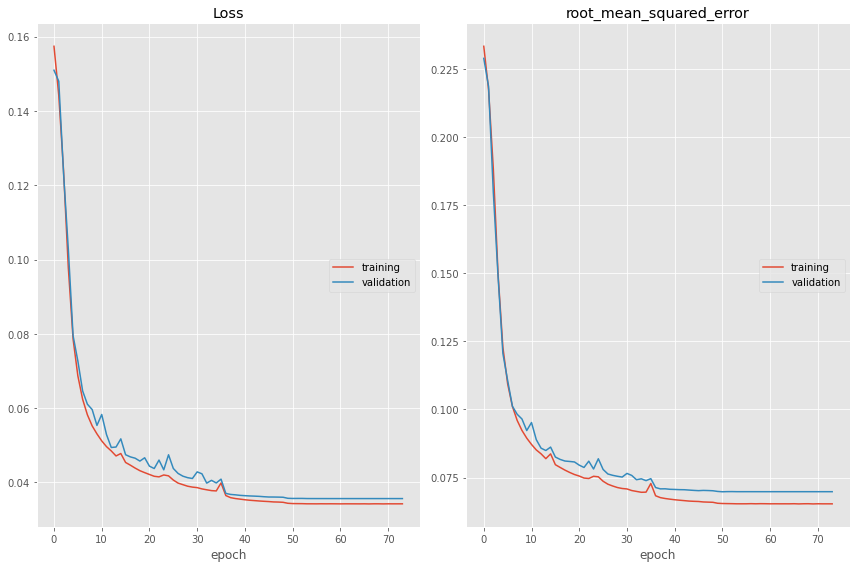

Loss
	training         	 (min:    0.034, max:    0.157, cur:    0.034)
	validation       	 (min:    0.036, max:    0.151, cur:    0.036)
root_mean_squared_error
	training         	 (min:    0.065, max:    0.233, cur:    0.065)
	validation       	 (min:    0.070, max:    0.229, cur:    0.070)
438/438 [==============================] - 18s 42ms/step - loss: 0.0342 - root_mean_squared_error: 0.0654 - val_loss: 0.0356 - val_root_mean_squared_error: 0.0698 - lr: 1.0000e-12


In [77]:
compile_and_fit(model, train_ds, val_ds, epochs=1000, patience_es=15, patience_lr=3)

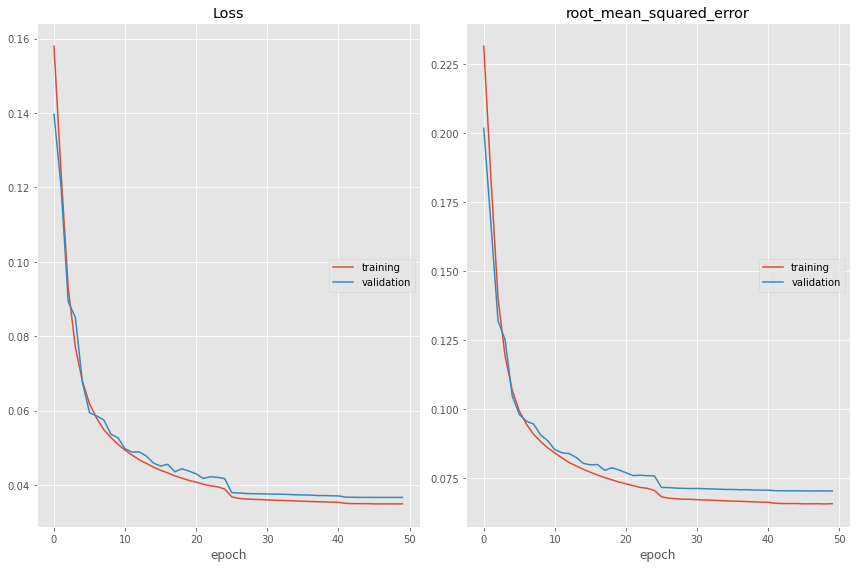

Loss
	training         	 (min:    0.035, max:    0.158, cur:    0.035)
	validation       	 (min:    0.037, max:    0.140, cur:    0.037)
root_mean_squared_error
	training         	 (min:    0.066, max:    0.231, cur:    0.066)
	validation       	 (min:    0.070, max:    0.202, cur:    0.070)
419/419 [==============================] - 17s 41ms/step - loss: 0.0349 - root_mean_squared_error: 0.0657 - val_loss: 0.0366 - val_root_mean_squared_error: 0.0704 - lr: 1.0000e-07
Epoch 51/1000
  1/419 [..............................] - ETA: 16s - loss: 0.0348 - root_mean_squared_error: 0.0643

In [ ]:
compile_and_fit(model, train_ds, val_ds, epochs=1000, patience_es=15, patience_lr=3)

In [92]:
# model.load_weights(join(PATH.ckpt, "[030 epoch].h5"))

# 5. Result

## - Training, validation set

In [ ]:
plt.style.use('ggplot')

In [93]:
def plot_result(model, scaler_X, scaler_y, datasets, n_cols=5, figsize=(40, 20)):
    def metric(y, p):
        res = y-p
        res = res[~np.isnan(res)]
        return (np.abs(res).mean() + np.sqrt(((res)**2).mean()))/2
    
    for name, ds in datasets.items():
        ys_scale = []
        ps_scale = []
        for X_scale, y_scale in ds.as_numpy_iterator():
            p_scale = model.predict(X_scale, verbose=0)
            ys_scale.append(y_scale);  ps_scale.append(p_scale)
        
        ys_scale = np.concatenate(ys_scale)
        ps_scale = np.concatenate(ps_scale)

        ys = inverse_scale(ys_scale, scaler_y)[..., -1].reshape(-1)
        ps = inverse_scale(ps_scale, scaler_y)[..., -1].reshape(-1)
        print(f"[{name}] mean(MAE, RMSE): {metric(ys, ps):.2f}")
        
        for X, y in ds.take(1):
            X = X[:n_cols]
            y = y[:n_cols]
        
        inputs = [pd.DataFrame(inverse_scale(d, scaler_X), columns=cols_X, dtype='float32') for d in X]
        trues  = [pd.DataFrame(inverse_scale(d, scaler_y), columns=cols_y) for d in y]
        preds  = [pd.DataFrame(inverse_scale(d, scaler_y), columns=cols_y) for d in model.predict(X, verbose=0)]
        
        for input, pred in zip(inputs, preds):
            pred['TurbID'] = input['TurbID'].round().values

        n_rows = y.shape[-1]
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        for ax_col, col in zip(axes, cols_y):
            for idx_row, (ax, true, pred) in enumerate(zip(ax_col, trues, preds)):
                ax.plot(true[col], label='true')
                ax.plot(pred[col], label=f'pred ({np.mean(abs(pred[col]-true[col])):.3f})')
                ax.fill_between(range(len(true[col])), true[col], pred[col], alpha=0.1, color='b')
                ax.set_xticklabels([])
                ax.legend()
                if idx_row == 0:
                    ax.set_ylabel(col)
        fig.tight_layout()
        plt.show()

[train] mean(MAE, RMSE): 114.70


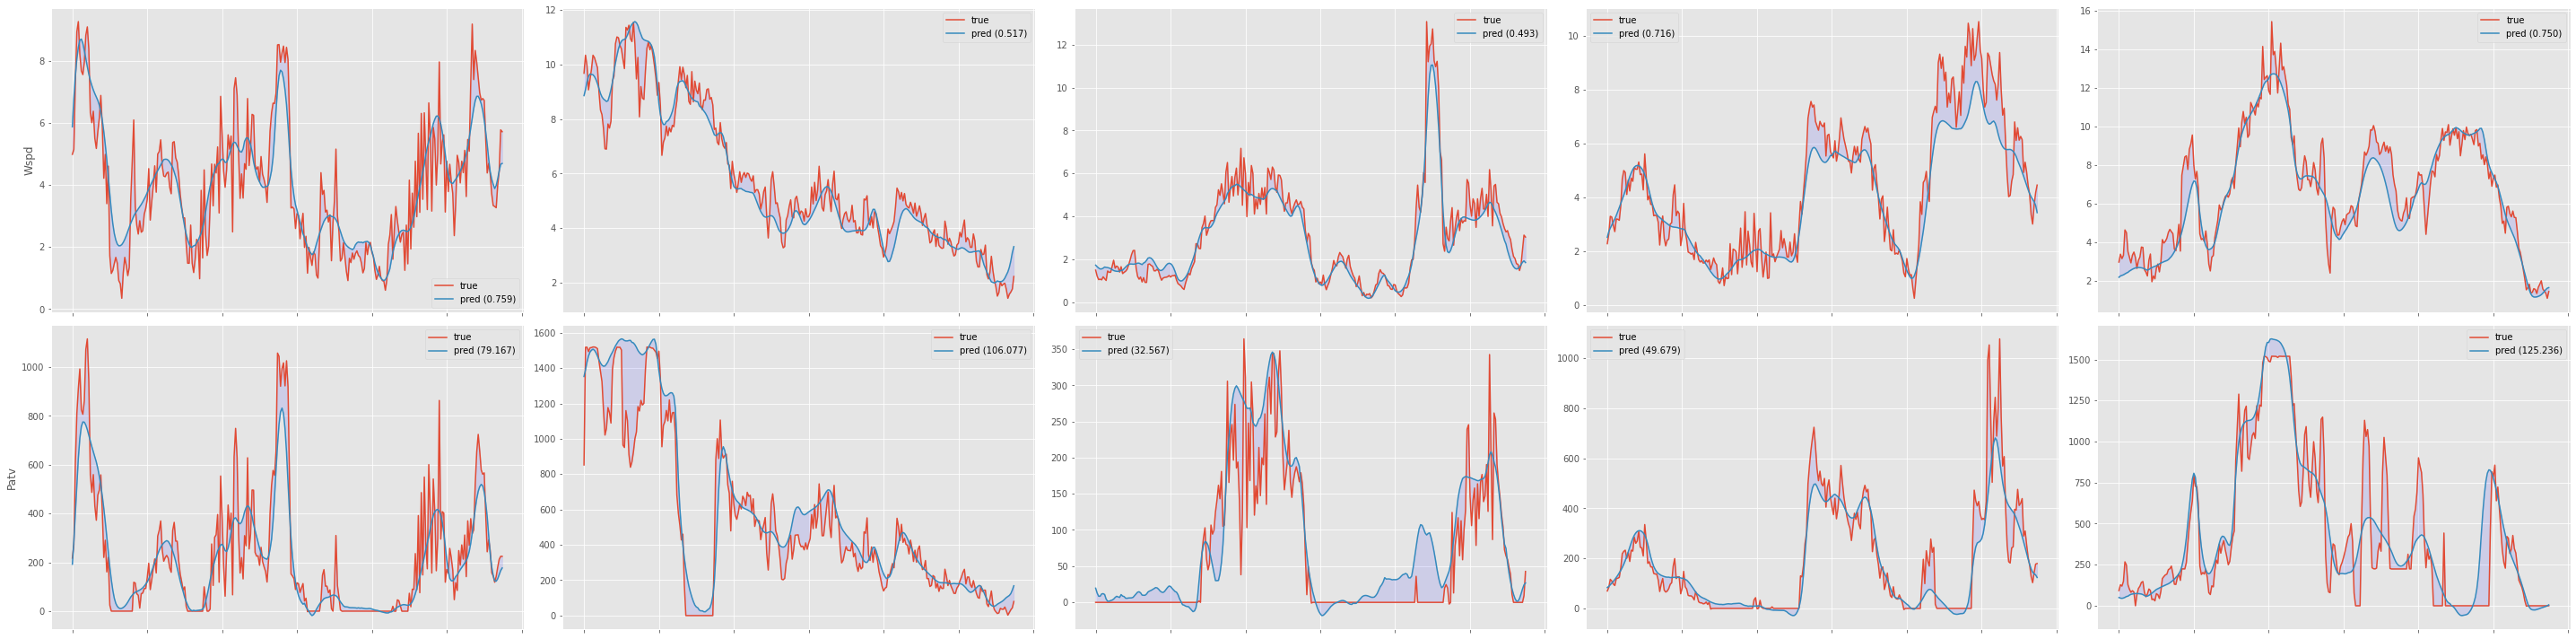

[val] mean(MAE, RMSE): 122.20


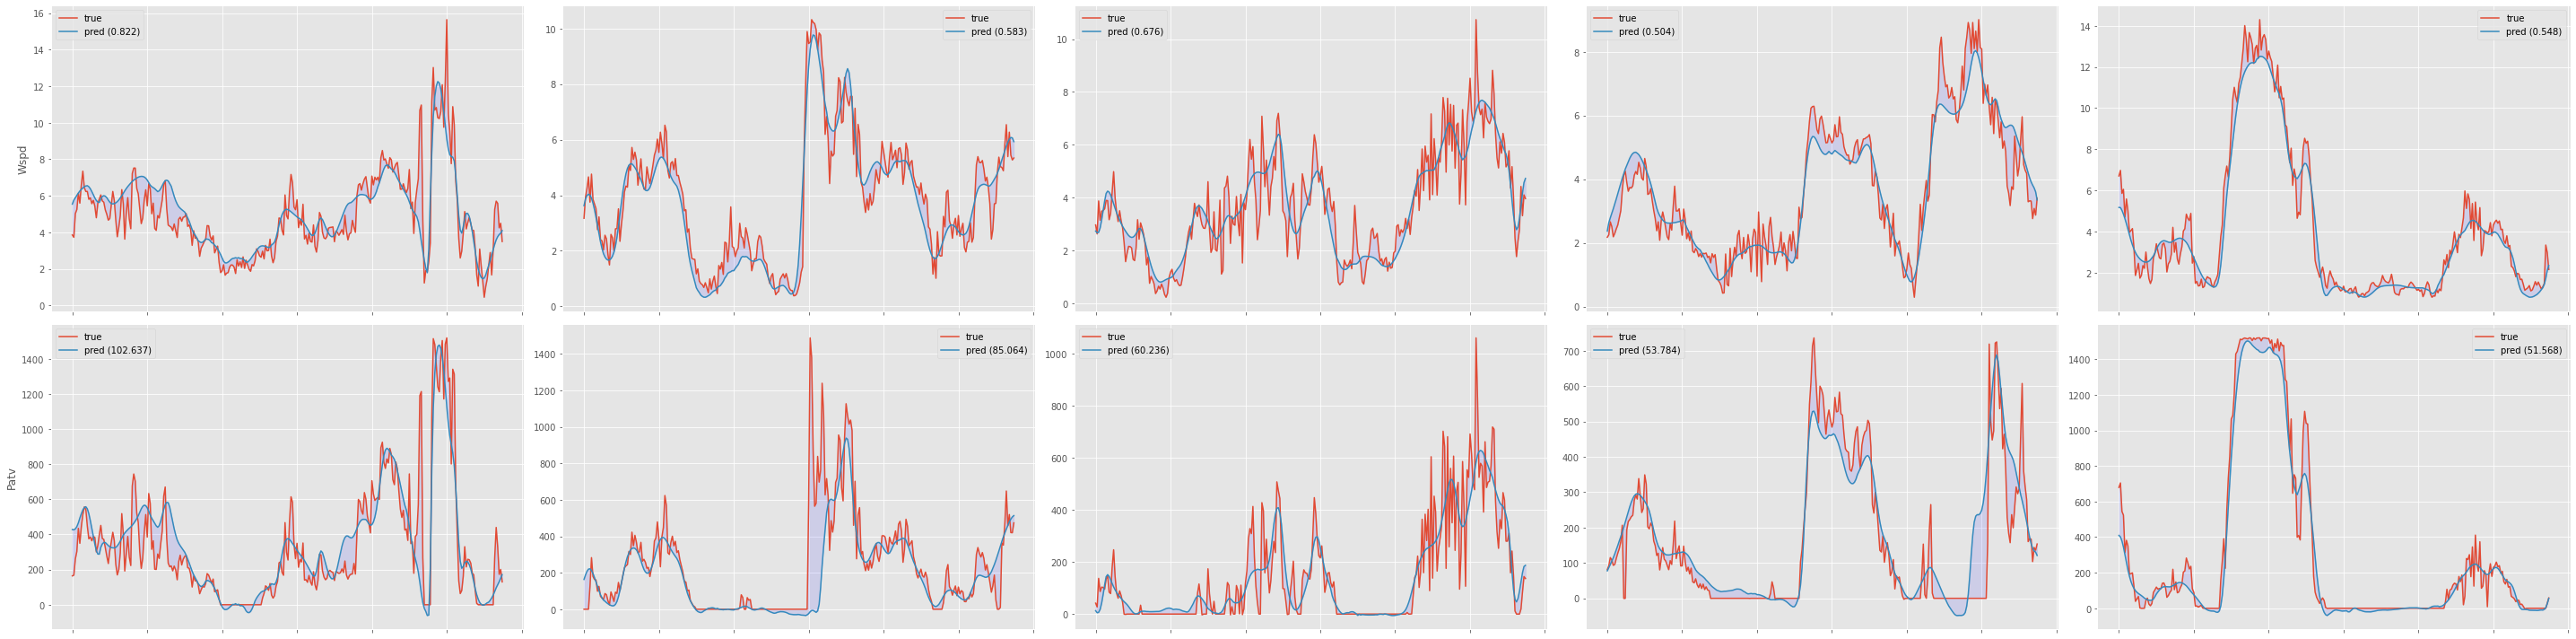

In [94]:
plot_result(model, scaler_X, scaler_y, {'train': train_ds, 'val': val_ds}, figsize=(40, 10))

## - Test set

[test] mean(MAE, RMSE): 399.48


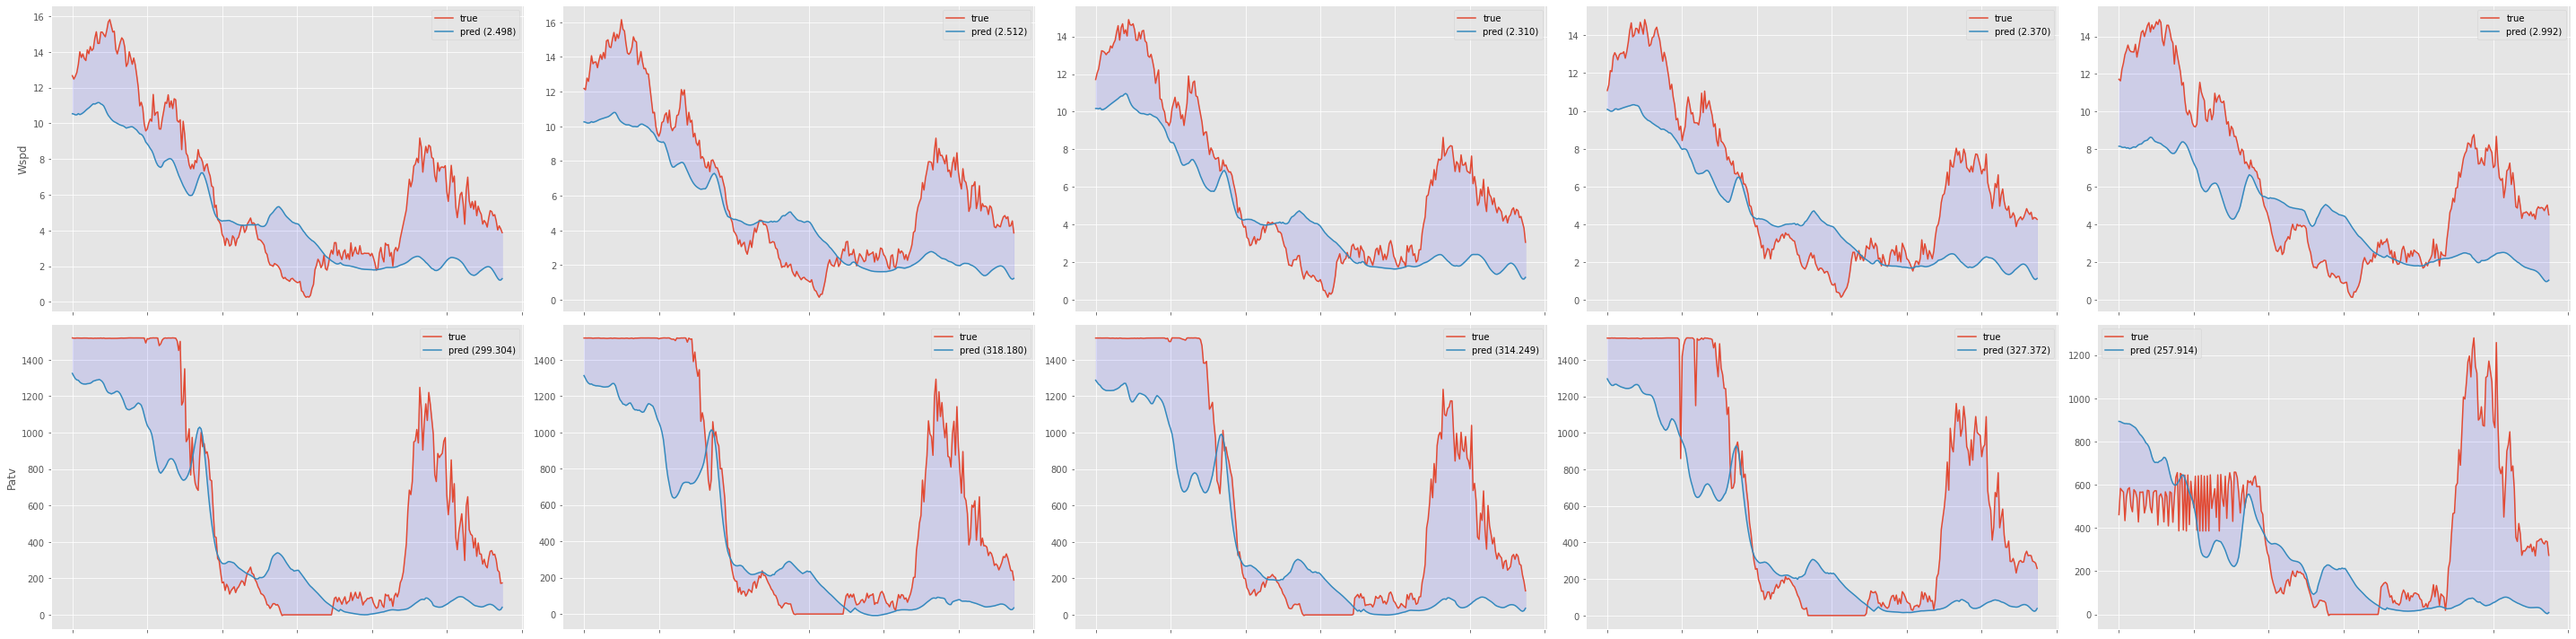

In [95]:
plot_result(model, scaler_X, scaler_y, {'test': test_ds}, figsize=(40, 10))